# Demos: Lecture 4

In [1]:
import pennylane as qml
from pennylane import numpy as np

Given a qubit in state 

$$
\vert \psi \rangle = \frac{\sqrt{3}}{2} \vert 0 \rangle - \frac{1}{2}e^{i\frac{5}{4}} \vert 1 \rangle
$$

what is the measurement outcome probability of $|p\rangle$ if we measure in the $\{|p\rangle, |m\rangle\}$ basis? Evaluate the inner product using NumPy.

In [2]:
psi = np.array([np.sqrt(3)/2, -0.5 * np.exp(1j*5/4)])
p = np.array([1/np.sqrt(2), 1j/np.sqrt(2)])
m = np.array([1/np.sqrt(2), -1j/np.sqrt(2)])

In [3]:
np.abs(np.vdot(p, psi)) ** 2

0.08907760591867832

In [4]:
np.abs(np.vdot(m, psi)) ** 2

0.9109223940813213

## Exercise 1: $Y$-basis rotation

In [5]:
dev = qml.device('default.qubit', wires=1)
  
def convert_to_y_basis():
    # YOUR CODE HERE; find a circuit that sends 
    # |0> -> |p> and |1> -> |m>
    qml.Hadamard(wires=0)
    qml.S(wires=0)
    

# Compute the measurement outcome probabilities of state
#     sqrt(3)/2 |0> - (1/2)e^(i5/4) |1> 
# if measuring in this basis.
@qml.qnode(dev)
def rotate_basis():
    # State preparation
    qml.RY(-np.pi/3, wires=0)
    qml.PhaseShift(5/4, wires=0)
    
    # Basis rotation
    adjoint_rotation = qml.adjoint(convert_to_y_basis)
    adjoint_rotation()
    
    return qml.probs(wires=0)

In [6]:
rotate_basis()

tensor([0.08907761, 0.91092239], requires_grad=True)

Same result as from NumPy!

In [7]:
print(qml.draw(rotate_basis)())

0: ──RY(-1.05)──Rϕ(1.25)──S⁻¹──H─┤  Probs


(<Figure size 504x144 with 1 Axes>, <Axes:>)

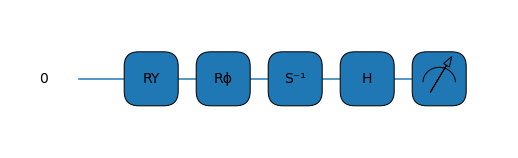

In [8]:
qml.draw_mpl(rotate_basis)()

## Demo 1: `qml.ctrl`

Implement the following circuit; apply the controlled operations in two different ways.

<img src="fig/mq-circuit.png" width=600>

In [9]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def circuit(x, y, z):
    qml.CRX(x, wires=[0, 1])
    
    # CRY does exist, but let's use qml.ctrl just to see
    # how we can do it in a different way
    qml.ctrl(qml.RY, control=0)(y, wires=2)
   
    qml.RX(x, wires=0)
    qml.RY(y, wires=1)
    qml.RZ(z, wires=2)
    qml.Hadamard(wires=2)
    
    # Return measurement outcome probabilities of only the
    # last two wires
    return qml.probs(wires=[1, 2])

In [10]:
circuit(0.1, 0.2, 0.3)

tensor([0.49501664, 0.49501664, 0.00498336, 0.00498336], requires_grad=True)

I did this demo for some students after class; posting here so everyone can see. The `qml.ctrl` transform can be applied to subroutines as well.

In [11]:
dev = qml.device("default.qubit", wires=3)

# Some parametrized subroutine; it acts only on qubits 1 
# and 2; we will apply it controlled on qubit 0.
def random_function(param):
    qml.RY(param, wires=1)
    qml.SWAP(wires=[1, 2])
    qml.S(wires=2)

@qml.qnode(dev)
def circuit(x, y, z):
    qml.CRX(x, wires=[0, 1])
    qml.ctrl(qml.RY, control=0, control_values="0")(y, wires=2)
    
    qml.RX(x, wires=0)
    qml.RY(y, wires=1)
    qml.RZ(z, wires=2)
    qml.Hadamard(wires=2)
    
    # Here we apply the controlled subroutine
    qml.ctrl(random_function, control=0)(0.2)
    
    return qml.probs(wires=[1, 2])

Below we draw the circuit; setting the kwarg `expansion_strategy="device"` just ensures that in the printed out version, it will unroll the controlled subroutine into individual gates (you can check also what happens if you remove it).

In [12]:
print(qml.draw(circuit, expansion_strategy="device")(0.1, 0.2, 0.3))

0: ─╭C────────╭C─────────RX(0.10)─╭C────────╭C────╭C────────┤       
1: ─╰RX(0.10)─│──────────RY(0.20)─╰RY(0.20)─├SWAP─│─────────┤ ╭Probs
2: ───────────╰RY(0.20)──RZ(0.30)──H────────╰SWAP─╰Rϕ(1.57)─┤ ╰Probs
